In [1]:
import numpy as np    
import pandas as pd
import matplotlib.pyplot as plt

from pykat import finesse                 
from pykat.commands import *               
from pykat.optics.maps import * 
from pykat.parallel import parakat

%config InlineBackend.figure_format='svg'
%matplotlib inline
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 1.2.1           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## Content: 
This notebook calculates the contrast defects of HG33 and LG22 mode in a Fabry–Perot Michelson interferometer with four different random maps applied to the mirrors

## Workflow:
1. Find the correct tunings for ITMs, ETMs and beamsplitter by using the CARM, DARM and MICH error signals respectively.
2. Calculate the contrast defects for HG33, LG22 and HG00 mode. For each mode, three different cases are considered: no maps applied, with maps but without lock commands, with maps and with locks.
3. Compare the results of with maps and locks for HG33 and LG22 mode

In [18]:
HG33base = finesse.kat()         
HG33base.verbose = False
HG33base.parse( """
l laser 100 0 n0          
s s0 1 n0 n1                        
maxtem 8

mod EOM1 $fEOM 0.3 1 pm 0 n1 n2
s s1 0 n2 nBSb

## Central beam splitter ##
bs1 BS 0.5 3.75e-05 0 45 nBSb nBSy nBSx nBSd 

#higher order mode HG33
tem laser 0 0 0.0 0.0
tem laser 3 3 1.0 0.0


## X arm ##                   
s slX 6.9 nBSx nX1
m1 ITMX 0.014 3.75e-05 0 nX1 nX2
s sLX 3994.4692 nX2 nX3 
m1 ETMX 5e-06 3.75e-05 0 nX3 dump
cav cavityX ITMX nX2 ETMX nX3

## Y arm ##
s slY 7.1 nBSy nY1
m1 ITMY 0.014 3.75e-05 0 nY1 nY2
s sLY 3994.4692 nY2 nY3 
m1 ETMY 5e-06 3.75e-05 0 nY3 dump
cav cavityY ITMY nY2 ETMY nY3

# 1ppm again
attr ETMX Rc 2679.93
attr ETMY Rc 2679.93
attr ITMX Rc -2679.93
attr ITMY Rc -2679.93

const fEOM 10M

"""
)      

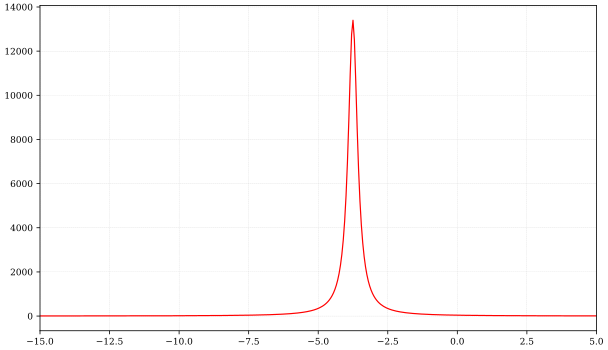

In [17]:
# Find the right tuning for the ITMs by making sure the power inside the cavity is at its maximum
HGkat = HG33base.deepcopy()
HGkat.parse("""
pd Pcirc nX3
xaxis ITMX phi lin -15 5 400
""")
out1 = HGkat.run()

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out1.x, out1['Pcirc'],'r')

# Zoom in to [-4,-3](need to change the above code to 'xaxis ITMX phi lin -4 -3 400' of course)
ITMstuning = -4+(1/400)*np.argmax(np.abs(out1["Pcirc"]))

In [3]:
# Gives the ITM tunings
ITMstuning

-3.75425

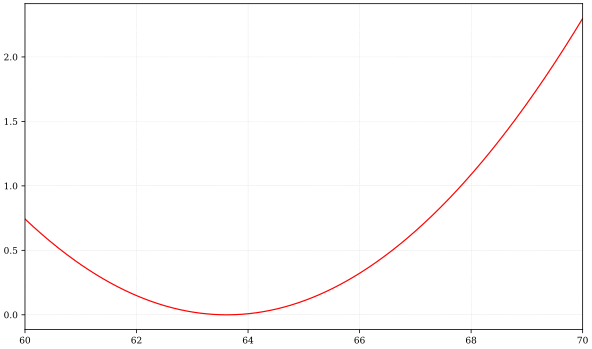

In [9]:
# Find the right tuning for the BS by making sure the carrier is at the dark fringe

HGkat = HG33base.deepcopy()
HGkat.ITMY.phi = -3.75425 # Use the result above
HGkat.ITMX.phi = -3.75425
HGkat.parse("""
ad Carrier 3 3 0 nBSd
xaxis BS phi lin 60 70 400
""")
out1 = HGkat.run()
fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out1.x, np.abs(out1["Carrier"])**2,'r') # This is to make the plot


# Zoom in to [63,64]
HGkat = HG33base.deepcopy()
HGkat.ITMY.phi = -3.75425
HGkat.ITMX.phi = -3.75425
HGkat.parse("""
ad Carrier 3 3 0 nBSd
xaxis BS phi lin 63 64 400
""")
out2 = HGkat.run()
BStuning = 63+(1/400)*np.argmin(np.abs(out2["Carrier"])**2) # This is to calculate the tuning after zooming in

In [30]:
# Gives the BS tuning
BStuning

63.61875

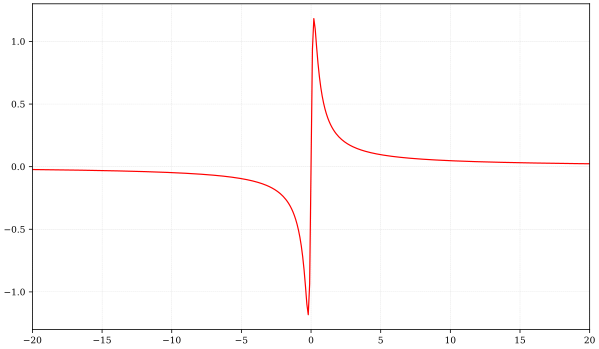

In [18]:
# Find the right tuning for the ETMs by using the error signal of DARM
HGkat = HG33base.deepcopy()
HGkat.ITMY.phi = -3.75425
HGkat.ITMX.phi = -3.75425
HGkat.BS.phi = 63.61875
HGkat.parse("""
# error signal for DARM dof

const fEOM 10M
xaxis ETMX phi lin -20 20 400
put ETMY phi $mx1
pd1 DARM $fEOM 90 nBSd
""")
out1 = HGkat.run() # This is to plot the error signal
fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out1.x, out1['DARM'],'r')

# Zoom in to [-1,0]
HGkat = HG33base.deepcopy()
HGkat.ITMY.phi = -3.75425
HGkat.ITMX.phi = -3.75425
HGkat.BS.phi = 63.61875
HGkat.parse("""
# error signal for DARM dof
const fEOM 10M
xaxis ETMX phi lin -1 0 400
put ETMY phi $mx1
pd1 DARM $fEOM 90 nBSd

""")
out2 = HGkat.run()
DARM = -1+(1/400)*np.argmax(np.abs(out2["DARM"])) # This is to calculate the tuning after zooming in

In [4]:
# Gives the ETM tunings
DARM

0

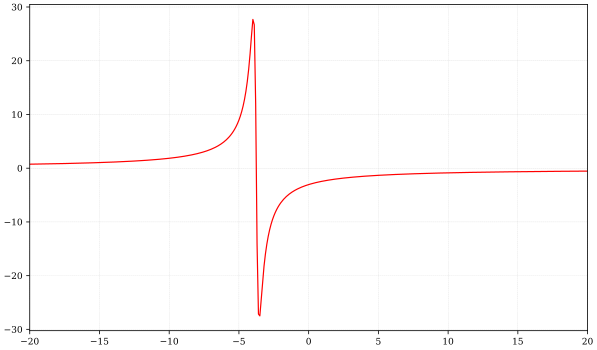

In [35]:
# This is to confirm the ITM tunings by using the error signal of CARM
HGkat = HG33base.deepcopy()
HGkat.ETMY.phi = 0
HGkat.ETMX.phi = 0
HGkat.BS.phi = 63.61875
HGkat.parse("""
# error signal for CARM dof
const fEOM 10M
xaxis ITMX phi lin -20 20 400
put ITMY phi $x1
pd1 CARM $fEOM 0 nBSb
""")
out1 = HGkat.run()
fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out1.x, out1['CARM'],'r')


HGkat = HG33base.deepcopy()
HGkat.ETMY.phi = 0
HGkat.ETMX.phi = 0
HGkat.BS.phi = 63.61875
HGkat.parse("""
# error signal for CARM dof
const fEOM 10M
xaxis ITMX phi lin -5 -3 400
put ITMY phi $x1
pd1 CARM $fEOM 0 nBSb

""")
out2 = HGkat.run()
CARM = -5+(2/400)*np.argmin(np.abs(out2["CARM"]))

In [5]:
# The result is the same for the ITM tunings
CARM

-3.75425

In [19]:
# Contrast defects in the case of no maps

HG33kat = HG33base.deepcopy() 
HG33kat.ETMY.phi = 0 # correct tunings of ETMs, ITMs and BS using DARM/CARM/MICH error signals
HG33kat.ETMX.phi = 0
HG33kat.ITMY.phi = -3.75425
HG33kat.ITMX.phi = -3.75425
HG33kat.BS.phi = 63.61875
HG33kat.parse(f"""
pd darkport nBSd
pd brightport nBSb
pd power nX3
""")
HG33kat.noxaxis = True
out = HG33kat.run()
contrastnomap=out['darkport']/out['brightport']
powerHG = out['power'] # The circulating power is to make sure the locks are working properly later
print(f'The contrast defect without random maps is {contrastnomap} \n')
print(f'The circulating power without random maps is {powerHG}[W]')

CDdfHG33 = pd.DataFrame()
CDdfHG33['without maps'] = contrastnomap*np.ones(14) # Make the first column of 'without maps' for the DataFrame

The contrast defect without random maps is 7.904961267936149e-05 

The circulating power without random maps is 13404.1461516851[W]


In [20]:
# Contrast defects in the case of maps but no locks

pk=parakat()
for i in range(0,53,4):# So that for the first iteration the random maps applied are randommap0~randommap3, 
    # in the second iteration the random maps are randommap4~randommap7. The maps will not be reused.
    HG33kat = HG33base.deepcopy() 
    HG33kat.ETMY.phi = 0 # correct tunings using CARM/DARM/MICH error signals
    HG33kat.ETMX.phi = 0
    HG33kat.ITMY.phi = -3.75425
    HG33kat.ITMX.phi = -3.75425
    HG33kat.BS.phi = 63.61875
    HG33kat.parse(f"""
    map ETMY randommaps/randommap{i}.txt
    map ETMX randommaps/randommap{i+1}.txt
    map ITMY randommaps/randommap{i+2}.txt
    map ITMX randommaps/randommap{i+3}.txt
    
    pd darkport nBSd
    pd brightport nBSb
    
    """)
    HG33kat.noxaxis = True
    pk.run(HG33kat)
out = pk.getResults()

contrastnolock = []
for i in range(14):
    contrast=out[i]['darkport']/out[i]['brightport']
    contrastnolock.append(contrast)

CDdfHG33['with maps without lock'] = contrastnolock

Parallel jobs: 100%|##########################################################|

In [22]:
contrastnolock

[0.020761589853726566,
 0.26696748171673296,
 0.039716173931565193,
 0.027945317354414294,
 0.03875002789798106,
 0.084624249359185,
 0.022187428730038337,
 0.12496702191314837,
 0.06373095214876344,
 0.03942406045366935,
 0.04922300482872543,
 0.006500173979998019,
 0.014337233873750084,
 0.002360842293412475]

In [23]:
# Contrast defects in the case of maps and locks

pk=parakat()
for i in range(0,53,4):
    HG33kat = HG33base.deepcopy() 
    HG33kat.ETMY.phi = 0 
    HG33kat.ETMX.phi = 0
    HG33kat.ITMY.phi = -3.75425
    HG33kat.ITMX.phi = -3.75425
    HG33kat.BS.phi = 63.61875 
    HG33kat.parse(f"""
    map ETMY randommaps/randommap{i}.txt
    map ETMX randommaps/randommap{i+1}.txt
    map ITMY randommaps/randommap{i+2}.txt
    map ITMX randommaps/randommap{i+3}.txt
  
    # CARM error signal and lock for ITMs tuning
    const fEOM 10M
    pd1 CARM $fEOM 0 nBSb
    set CARMerr CARM re
    lock CARMlock $CARMerr 1e-3 1n # The gain is set to be -1/slope
    func ITMphi = $CARMlock/2
    put ITMY phi $ITMphi
    put ITMX phi $ITMphi

    # DARM error signal and lock for ETMs tunings
    pd1 DARM $fEOM 90 nBSd
    set DARMerr DARM re
    lock DARMlock $DARMerr -1e-1 1n # The gain is set to be -1/slope
    func ETMXphi=$DARMlock/2
    func ETMYphi=(-1)*$ETMXphi
    put ETMY phi $ETMYphi
    put ETMX phi $ETMXphi

    pd darkport nBSd
    pd brightport nBSb
    pd power nX3

    """)
    HG33kat.noxaxis = True
    pk.run(HG33kat)
out = pk.getResults()

contrastHG = []
for i in range(14):
    contrast=out[i]['darkport']/out[i]['brightport']
    contrastHG.append(contrast)

CDdfHG33['with maps with lock'] = contrastHG

Parallel jobs: 100%|##########################################################|

In [26]:
print(f'The circulating power without random maps is {powerHG}[W]')

The circulating power without random maps is 13404.1461516851[W]


In [27]:
print('The relative circulating power is: \n')
for i in range(14):
    print(out[i]['power']/powerHG)

The relative circulating power is: 

0.9932759609090229
0.9979315414265746
0.976973572147257
0.9905497103333154
0.9878688958962778
0.9995478429369604
0.9953569375840419
0.9963160777035999
0.9948862869384946
0.9899648399219827
0.991605648038353
0.9986273332990638
0.9996090018364175
0.9980642089607373


In [28]:
# The contrast defect of HG33 mode for the three different cases
CDdfHG33.to_pickle('pkl/HG33contrastDefects.pkl')
CDdfHG33

,without maps,with maps without lock,with maps with lock
0,0.00007905,0.02076159,0.00077758
1,0.00007905,0.26696748,0.01503682
2,0.00007905,0.03971617,0.03953918
3,0.00007905,0.02794532,0.00388040
4,0.00007905,0.03875003,0.00191671
5,0.00007905,0.08462425,0.00134447
6,0.00007905,0.02218743,0.01176517
7,0.00007905,0.12496702,0.00396132
8,0.00007905,0.06373095,0.03638090
9,0.00007905,0.03942406,0.02286965


The procedures of HG00 and LG22 are similar to HG33

In [29]:
HG00base = finesse.kat()         
HG00base.verbose = False
HG00base.parse( """
l laser 100 0 n0          
s s0 1 n0 n1                        
maxtem 3

mod EOM1 $fEOM 0.3 1 pm 0 n1 n2
s s1 0 n2 nBSb

## Central beam splitter ##
bs1 BS 0.5 3.75e-05 0 45 nBSb nBSy nBSx nBSd 


## X arm ##                   
s slX 6.9 nBSx nX1
m1 ITMX 0.014 3.75e-05 0 nX1 nX2
s sLX 3994.4692 nX2 nX3 
m1 ETMX 5e-06 3.75e-05 0 nX3 dump
cav cavityX ITMX nX2 ETMX nX3

## Y arm ##
s slY 7.1 nBSy nY1
m1 ITMY 0.014 3.75e-05 0 nY1 nY2
s sLY 3994.4692 nY2 nY3 
m1 ETMY 5e-06 3.75e-05 0 nY3 dump
cav cavityY ITMY nY2 ETMY nY3

# 1ppm again
attr ETMX Rc 2091.67
attr ETMY Rc 2091.67
attr ITMX Rc -2091.67
attr ITMY Rc -2091.67

const fEOM 10M

"""
)      

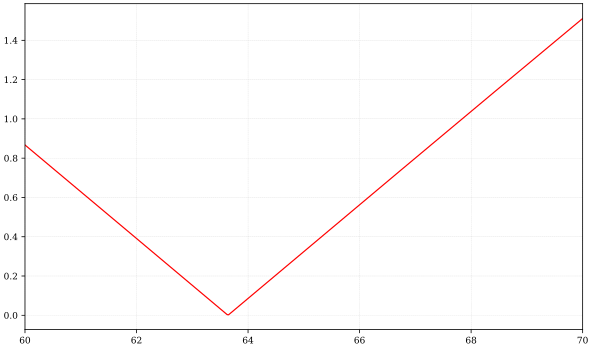

In [29]:
# Find the right tuning for the BS
HGkat = HG00base.deepcopy()
HGkat.ITMY.phi = 0
HGkat.ITMX.phi = 0
HGkat.parse("""
ad Carrier 0 0 0 nBSd
xaxis BS phi lin 60 70 400
""")
out1 = HGkat.run()

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out1.x, out1['Carrier'],'r')

HGkat = HG00base.deepcopy()
HGkat.ITMY.phi = 0
HGkat.ITMX.phi = 0
HGkat.parse("""
ad Carrier 0 0 0 nBSd
xaxis BS phi lin 62 64 400
""")
out2 = HGkat.run()

BStuning = 62+(2/400)*np.argmin(np.abs(out2["Carrier"]))

In [30]:
BStuning

63.64

In [30]:
# No maps case
HG00kat = HG00base.deepcopy() 
HG00kat.ETMY.phi = 0 
HG00kat.ETMX.phi = 0
HG00kat.ITMY.phi = 0
HG00kat.ITMX.phi = 0
HG00kat.BS.phi = 63.64
HG00kat.parse(f"""
pd darkport nBSd
pd brightport nBSb
    
""")
HG00kat.noxaxis = True
out = HG00kat.run()
contrastnomap=out['darkport']/out['brightport']
print(f'The contrast defect without map for HG00 is: {contrastnomap}')

CDdfHG00 = pd.DataFrame()
CDdfHG00['without maps'] = contrastnomap*np.ones(14)

The contrast defect without map for HG00 is: 7.898910907363643e-05


In [31]:
# with maps but no lock case
pk=parakat()
for i in range(0,53,4):
    HG00kat = HG00base.deepcopy() 
    HG00kat.ETMY.phi = 0 
    HG00kat.ETMX.phi = 0
    HG00kat.ITMY.phi = 0
    HG00kat.ITMX.phi = 0
    HG00kat.BS.phi = 63.64
    HG00kat.parse(f"""
    map ETMY randommaps/randommap{i}.txt
    map ETMX randommaps/randommap{i+1}.txt
    map ITMY randommaps/randommap{i+2}.txt
    map ITMX randommaps/randommap{i+3}.txt
    
    pd darkport nBSd
    pd brightport nBSb
    
    """)
    HG00kat.noxaxis = True
    pk.run(HG00kat)
out = pk.getResults()

contrastnolock = []
for i in range(14):
    contrast=out[i]['darkport']/out[i]['brightport']
    contrastnolock.append(contrast)

CDdfHG00['with maps without lock'] = contrastnolock

Parallel jobs: 100%|##########################################################|

In [32]:
# with maps and lock case
pk=parakat()  
for i in range(0,53,4):
    HG00kat = HG00base.deepcopy() 
    HG00kat.ETMY.phi = 0 
    HG00kat.ETMX.phi = 0
    HG00kat.ITMY.phi = 0
    HG00kat.ITMX.phi = 0
    HG00kat.BS.phi = 63.64
    HG00kat.parse(f"""
    map ETMY randommaps/randommap{i}.txt
    map ETMX randommaps/randommap{i+1}.txt
    map ITMY randommaps/randommap{i+2}.txt
    map ITMX randommaps/randommap{i+3}.txt
  
    # CARM error signal and lock for ITMs tuning
    const fEOM 10M
    pd1 CARM $fEOM 0 nBSb
    set CARMerr CARM re
    lock CARMlock $CARMerr 1e-3 1u
    func ITMphi = $CARMlock/2
    put ITMY phi $ITMphi
    put ITMX phi $ITMphi

    # DARM error signal and lock for ETMs tunings
    pd1 DARM $fEOM 90 nBSd
    set DARMerr DARM re
    lock DARMlock $DARMerr -1e-1 1u
    func ETMXphi=$DARMlock/2
    func ETMYphi=(-1)*$ETMXphi
    put ETMY phi $ETMYphi
    put ETMX phi $ETMXphi

    pd darkport nBSd
    pd brightport nBSb


    """)
    HG00kat.noxaxis = True
    pk.run(HG00kat)
out = pk.getResults()

contrastHG00 = []
for i in range(14):
    contrast=out[i]['darkport']/out[i]['brightport']
    contrastHG00.append(contrast)

CDdfHG00['with maps with lock'] = contrastHG00

Parallel jobs: 100%|##########################################################|

In [33]:
# The contrast defect of HG00 mode

pd.set_option("display.precision", 9)
CDdfHG00.to_pickle('pkl/HG00contrastDefects.pkl')
CDdfHG00

,without maps,with maps without lock,with maps with lock
0,0.000078989,0.000079287,0.000079287
1,0.000078989,0.000080556,0.000080555
2,0.000078989,0.000080924,0.000080907
3,0.000078989,0.000080766,0.000080766
4,0.000078989,0.000080565,0.000080565
5,0.000078989,0.000080443,0.000080441
6,0.000078989,0.000079745,0.000079743
7,0.000078989,0.000079637,0.000079628
8,0.000078989,0.000079488,0.000079488
9,0.000078989,0.000081257,0.000081221


In [34]:
LG22base = finesse.kat()         
LG22base.verbose = False
LG22base.parse( """
l laser 100 0 n0          
s s0 1 n0 n1                        
maxtem 8

#higher order mode LG22
tem laser 0 0 0 0
tem laser 6 0 0.234375 0
tem laser 5 1 0.15625 -90
tem laser 4 2 0.015625 0
tem laser 3 3 0.1875 -90
tem laser 2 4 0.015625 180
tem laser 1 5 0.15625 -90
tem laser 0 6 0.234375 180


mod EOM1 $fEOM 0.3 1 pm 0 n1 n2
s s1 0 n2 nBSb

## Central beam splitter ##
bs1 BS 0.5 3.75e-05 0 45 nBSb nBSy nBSx nBSd 


## X arm ##                   
s slX 6.9 nBSx nX1
m1 ITMX 0.014 3.75e-05 0 nX1 nX2
s sLX 3994.4692 nX2 nX3 
m1 ETMX 5e-06 3.75e-05 0 nX3 dump
cav cavityX ITMX nX2 ETMX nX3

## Y arm ##
s slY 7.1 nBSy nY1
m1 ITMY 0.014 3.75e-05 0 nY1 nY2
s sLY 3994.4692 nY2 nY3 
m1 ETMY 5e-06 3.75e-05 0 nY3 dump
cav cavityY ITMY nY2 ETMY nY3

# 1ppm again
attr ETMX Rc 2789.58
attr ETMY Rc 2789.58
attr ITMX Rc -2789.58
attr ITMY Rc -2789.58

const fEOM 10M

"""
)      

The resonance power is 13362.9635090159


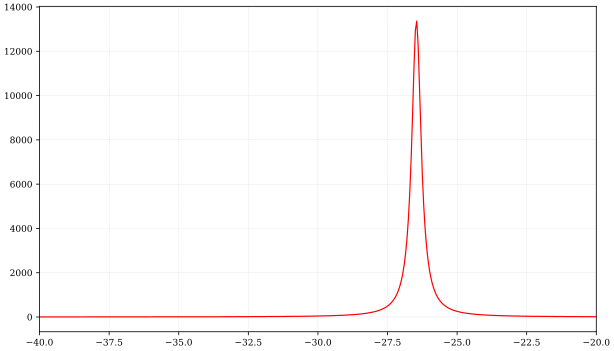

In [9]:
# get the right tuning for the ITMs

LGkat = LG22base.deepcopy()
LGkat.parse("""
pd Pcirc nX3
xaxis ITMX phi lin -40 -20 400
""")
out = LGkat.run()

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out.x, out['Pcirc'],'r')

ITMstuningLG22 = -27 + (2/400)*np.argmax(np.abs(out["Pcirc"]))
power = np.max(out['Pcirc'])
print(f'The resonance power is {power}')

In [11]:
ITMstuningLG22

-26.46

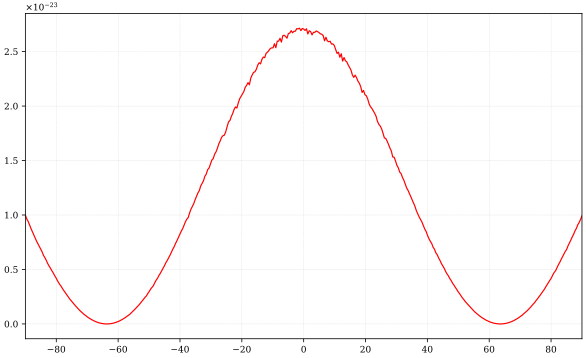

In [13]:
# get the right tuning for the BS
LGkat = LG22base.deepcopy()
LGkat.ITMY.phi = -26.46
LGkat.ITMX.phi = -26.46
LGkat.parse("""
ad AD60 6 0 0 nBSd
ad AD51 5 1 0 nBSd
ad AD42 4 2 0 nBSd
ad AD33 3 3 0 nBSd
ad AD24 2 4 0 nBSd
ad AD15 1 5 0 nBSd
ad AD06 0 6 0 nBSd
yaxis abs:deg
    
xaxis BS phi lin -90 90 400
""")
out = LGkat.run()

LGmode=0
for n in range(7):
    for m in range(6,-1,-1):
        if n+m==6:
            coeff,p,l = pykat.optics.gaussian_beams.HG2LG(n,m)
            LGmode += coeff[np.where(l == 2)]*out[f"AD{n}{m}"] # Find the carrier(LG22) field amplitude from all the amplitude 
            # detectors of order 6

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out.x, np.abs(LGmode)**2,'r')

LGkat1 = LG22base.deepcopy()
LGkat1.ITMY.phi = -26.46
LGkat1.ITMX.phi = -26.46
LGkat1.parse("""
ad AD60 6 0 0 nBSd
ad AD51 5 1 0 nBSd
ad AD42 4 2 0 nBSd
ad AD33 3 3 0 nBSd
ad AD24 2 4 0 nBSd
ad AD15 1 5 0 nBSd
ad AD06 0 6 0 nBSd
yaxis abs:deg
    
xaxis BS phi lin 63 64 4000
""")
out1 = LGkat1.run()
LGmode=0
for n in range(7):
    for m in range(6,-1,-1):
        if n+m==6:
            coeff,p,l = pykat.optics.gaussian_beams.HG2LG(n,m)
            LGmode += coeff[np.where(l == 2)]*out1[f"AD{n}{m}"]

BStuning = 63+(1/4000)*np.argmin(np.abs(LGmode)**2)

In [14]:
BStuning

63.612

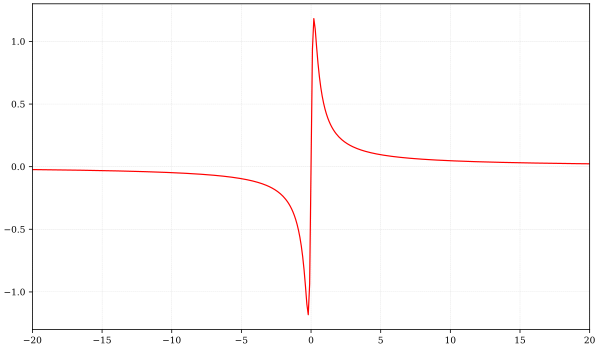

In [33]:
# Find the tunings for ETMs
LGkat = LG22base.deepcopy()
LGkat.ITMY.phi = -26.46
LGkat.ITMX.phi = -26.46
LGkat.BS.phi = 63.612
LGkat.parse("""
# error signal for DARM dof
const fEOM 10M
xaxis ETMX phi lin -20 20 400
put ETMY phi $mx1
pd1 DARM $fEOM 90 nBSd
""")
out1 = LGkat.run()

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out1.x, out1['DARM'],'r')

LGkat.parse("""
# error signal for DARM dof
const fEOM 10M
xaxis ETMX phi lin -1 1 400
put ETMY phi $mx1
pd1 DARM $fEOM 90 nBSd

""")
out2 = LGkat.run()
DARM = -1+(2/400)*np.argmin(np.abs(out2["DARM"]))

In [42]:
DARM

0.0

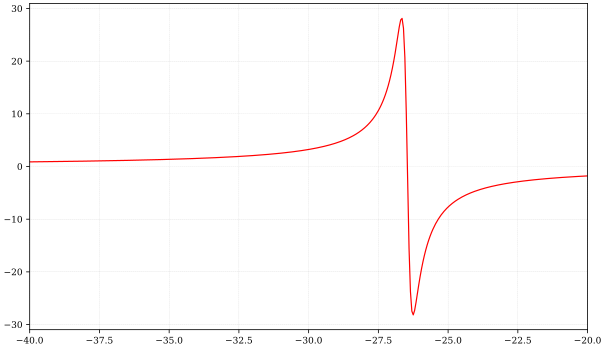

In [24]:
# ITM tunings
LGkat = LG22base.deepcopy()
LGkat.ETMY.phi = 0
LGkat.ETMX.phi = 0
LGkat.BS.phi = 63.612
LGkat.parse("""
# error signal for CARM dof
const fEOM 10M
xaxis ITMX phi lin -40 -20 400
put ITMY phi $x1
pd1 CARM $fEOM 0 nBSb
""")
out1 = LGkat.run()

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(out1.x, out1['CARM'],'r')

In [35]:
# No maps
LG22kat = LG22base.deepcopy() 
LG22kat.ETMY.phi = 0 # correct tunings using CARM/DARM/MICH error signals
LG22kat.ETMX.phi = 0
LG22kat.ITMY.phi = -26.46
LG22kat.ITMX.phi = -26.46
LG22kat.BS.phi = 63.612
LG22kat.parse(f"""
pd darkport nBSd
pd brightport nBSb
pd power nX3
""")
LG22kat.noxaxis = True
out = LG22kat.run()
contrastnomap=out['darkport']/out['brightport']
powerLG = out['power']
print(f'The contrast defect without map for LG22 is: {contrastnomap}')
print(f'The circulating power without map for LG22 is: {powerLG}[W]')

CDdfLG22 = pd.DataFrame()
CDdfLG22['without maps'] = contrastnomap*np.ones(14)

The contrast defect without map for LG22 is: 7.913516216627003e-05
The circulating power without map for LG22 is: 13403.7351937903[W]


In [36]:
# with maps but no locks
pk=parakat()
for i in range(0,53,4):
    LG22kat = LG22base.deepcopy() 
    LG22kat.ETMY.phi = 0 # correct tunings using CARM/DARM/MICH error signals
    LG22kat.ETMX.phi = 0
    LG22kat.ITMY.phi = -26.46
    LG22kat.ITMX.phi = -26.46
    LG22kat.BS.phi = 63.612
    LG22kat.parse(f"""
    map ETMY randommaps/randommap{i}.txt
    map ETMX randommaps/randommap{i+1}.txt
    map ITMY randommaps/randommap{i+2}.txt
    map ITMX randommaps/randommap{i+3}.txt
    
    pd darkport nBSd
    pd brightport nBSb
    
    """)
    LG22kat.noxaxis = True
    pk.run(LG22kat)
out = pk.getResults()

contrastnolock = []
for i in range(14):
    contrast=out[i]['darkport']/out[i]['brightport']
    contrastnolock.append(contrast)

CDdfLG22['with maps without lock'] = contrastnolock

Parallel jobs: 100%|##########################################################|

In [37]:
contrastnolock

[0.008434474677722287,
 0.17874663330064494,
 0.052044583733774206,
 0.03502982369287899,
 0.023731858707408012,
 0.06626774147011204,
 0.02677963797707184,
 0.12873074086498634,
 0.06094365571944177,
 0.03653809863064152,
 0.054262116388066696,
 0.017645844307735952,
 0.03778695915656419,
 0.02987291974591901]

In [38]:
# With maps and locks
pk=parakat()  
for i in range(0,53,4):
    LG22kat = LG22base.deepcopy() 
    LG22kat.ETMY.phi = 0 # correct tunings using CARM/DARM/MICH error signals
    LG22kat.ETMX.phi = 0
    LG22kat.ITMY.phi = -26.46
    LG22kat.ITMX.phi = -26.46
    LG22kat.BS.phi = 63.612
    LG22kat.parse(f"""
    map ETMY randommaps/randommap{i}.txt
    map ETMX randommaps/randommap{i+1}.txt
    map ITMY randommaps/randommap{i+2}.txt
    map ITMX randommaps/randommap{i+3}.txt
  
    # CARM error signal and lock for ITMs tuning
    const fEOM 10M
    pd1 CARM $fEOM 0 nBSb
    set CARMerr CARM re
    lock CARMlock $CARMerr 5e-3 1u
    func ITMphi = $CARMlock/2
    put* ITMY phi $ITMphi
    put* ITMX phi $ITMphi


    # DARM error signal and lock for ETMs tunings
    pd1 DARM $fEOM 90 nBSd
    set DARMerr DARM re
    lock DARMlock $DARMerr -1e-1 1u
    func ETMXphi=$DARMlock/2
    func ETMYphi=(-1)*$ETMXphi
    put ETMY phi $ETMYphi
    put ETMX phi $ETMXphi

    pd darkport nBSd
    pd brightport nBSb
    pd Pcirc nX3
    """)
    LG22kat.noxaxis = True
    pk.run(LG22kat)
out = pk.getResults()

contrastLG22 = []
for i in range(14):
    contrast=out[i]['darkport']/out[i]['brightport']
    contrastLG22.append(contrast)

CDdfLG22['with maps with lock'] = contrastLG22

Parallel jobs: 100%|##########################################################|

In [39]:
# the ratio of the circulating power after applying maps and locks to the power without maps
# close to one meaning the lock commands are working properly
print('The circulating power is: \n')
for i in range(14):
    print(out[i]['Pcirc']/powerLG)

The circulating power is: 

0.9830770979848971
0.996735018190782
0.9694130518946588
0.98988409753505
0.9815948319103774
0.9958146329292755
0.9927112078868463
0.9754211976194271
0.9920917715541704
0.9874573099385322
0.9856666069222402
0.9907953464065854
0.995952355027878
0.9948151471069425


In [40]:
CDdfLG22.to_pickle('pkl/LG22contrastDefects.pkl')
CDdfLG22

,without maps,with maps without lock,with maps with lock
0,0.000079135,0.008434475,0.002297230
1,0.000079135,0.178746633,0.010295899
2,0.000079135,0.052044584,0.050043723
3,0.000079135,0.035029824,0.010288350
4,0.000079135,0.023731859,0.005556567
5,0.000079135,0.066267741,0.012612049
6,0.000079135,0.026779638,0.019983003
7,0.000079135,0.128730741,0.038521062
8,0.000079135,0.060943656,0.043866280
9,0.000079135,0.036538099,0.022438740


In [41]:
CDdfHG00 = pd.read_pickle('pkl/HG00contrastDefects.pkl')
CDdfHG33 = pd.read_pickle('pkl/HG33contrastDefects.pkl')
CDdfLG22 = pd.read_pickle('pkl/LG22contrastDefects.pkl')

cols = [('HG00', "no maps"), ('HG00', "maps no lock"), ('HG00', "maps and lock"),
         ('HG33', "no maps"), ('HG33', "maps no lock"), ('HG33', "maps and lock"),
         ('LG22', "no maps"), ('LG22', "maps no lock"), ('LG22', "maps and lock")]
cols = pd.MultiIndex.from_tuples(cols)
df = pd.DataFrame(np.concatenate((CDdfHG00.values, CDdfHG33.values, CDdfLG22.values), axis=1), columns=cols )
df.to_pickle('pkl/contrastDefects.pkl')

In [42]:
pd.set_option("display.precision", 8)
df = pd.read_pickle('pkl/contrastDefects.pkl')
df
# The contrast defect gets smaller when applied lock commands compared to no locks
# HG33 has smaller numbers than LG22

HG00                                   HG33               \
       no maps maps no lock maps and lock     no maps maps no lock   
0   0.00007899   0.00007929    0.00007929  0.00007905   0.02076159   
1   0.00007899   0.00008056    0.00008056  0.00007905   0.26696748   
2   0.00007899   0.00008092    0.00008091  0.00007905   0.03971617   
3   0.00007899   0.00008077    0.00008077  0.00007905   0.02794532   
4   0.00007899   0.00008057    0.00008056  0.00007905   0.03875003   
5   0.00007899   0.00008044    0.00008044  0.00007905   0.08462425   
6   0.00007899   0.00007974    0.00007974  0.00007905   0.02218743   
7   0.00007899   0.00007964    0.00007963  0.00007905   0.12496702   
8   0.00007899   0.00007949    0.00007949  0.00007905   0.06373095   
9   0.00007899   0.00008126    0.00008122  0.00007905   0.03942406   
10  0.00007899   0.00008153    0.00008152  0.00007905   0.04922300   
11  0.00007899   0.00007930    0.00007929  0.00007905   0.00650017   
12  0.00007899   0.00007995    0.00007995  0.00007905   0.01433723   
13  0.00007899   0.00008033    0.00008033  0.00007905   0.00236084   

                        LG22                             
   maps and lock     no maps maps no lock maps and lock  
0     0.00077758  0.00007914   0.00843447    0.00229723  
1     0.01503682  0.00007914   0.17874663    0.01029590  
2     0.03953918  0.00007914   0.05204458    0.05004372  
3     0.00388040  0.00007914   0.03502982    0.01028835  
4     0.00191671  0.00007914   0.02373186    0.00555657  
5     0.00134447  0.00007914   0.06626774    0.01261205  
6     0.01176517  0.00007914   0.02677964    0.01998300  
7     0.00396132  0.00007914   0.12873074    0.03852106  
8     0.03638090  0.00007914   0.06094366    0.04386628  
9     0.02286965  0.00007914   0.03653810    0.02243874  
10    0.02743517  0.00007914   0.05426212    0.03009854  
11    0.00658877  0.00007914   0.01764584    0.01742426  
12    0.00604026  0.00007914   0.03778696    0.03170806  
13    0.00083771  0.00007914   0.02987292    0.02703155

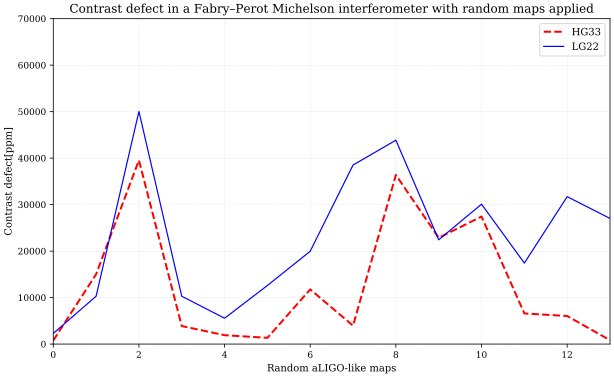

In [2]:
CDdf = pd.read_pickle('pkl/contrastDefects.pkl')

fig,ax =plt.subplots(figsize=(10,6))
ax.plot(CDdf['HG33']['maps and lock']*1e6,'r--',label='HG33',linewidth=2)
ax.plot(CDdf['LG22']['maps and lock']*1e6,'b',label='LG22')
#ax.plot(np.array(contrastHG00)*1e6,'c',label='HG00')
#ax.plot(np.array(contrastLG33)*1e6,'m',label='LG33')
ax.set_title('Contrast defect in a Fabry–Perot Michelson interferometer with random maps applied')
ax.set_xlabel("Random aLIGO-like maps")
ax.set_ylabel("Contrast defect[ppm]")
ax.set_ylim(0,70000)
ax.legend(loc='best')
plt.show()

# HG33 has smaller contrast defects than LG22 mode in the majority of the cases

In [26]:
fig.savefig('../contrastdefects.pdf')